# PIC 16B Final Project
### By:  Artem Kiryukhin and Karl Puttler

For this project we plan to use a dataset of 87,000 images of various American Sign Language hand signs to train a model which could accurately translate the hand signs to their appropriate meanings. We believe that this project could be a stepping stone to create a more inclusive environment for deaf people, a demographic that makes up over half a million people in the US. In addition to potentially making an impact for the deaf community we want to use the knowledge that we obtained from our math degrees to implement linear algebra and various mathematical imaging techniques (e.g. convolution) in a practical manner.

In order to complete this project we will utilize the aforementioned dataset (https://www.kaggle.com/datasets/grassknoted/asl-alphabet).



Below we import the necessary libraries

In [1]:
import torch
import numpy as np
from PIL import Image

from dataProcessing import *
from models import *
from workflow_functions import *

These are just some parameters for our data loading functions.

In [2]:
# set device to gpu if available and cpu if not
G_DEVICE            = torch.device("cuda") or torch.device("cpu")
G_BATCH_SIZE        = 128
G_NUM_WORKERS       = 16
G_TEST_IMG_PATH     = "ASL_Data/asl_alphabet_test/asl_alphabet_test"
G_TRAIN_IMG_PATH    = "ASL_Data/asl_alphabet_train/asl_alphabet_train"

# loss criteria for models when we use them
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)

## LeNet

LeNet5 was a model that was designed in 1998 by Yann LeCun and his colleagues. This model was one of the pioneering CNN models and proved to be incredibly effective. The model utilizes 2 convolutional layers, 2 maxpooling layers, and 3 fully connected layers. Overall we decided to implement this model because of its simplicity and the small amount of parameters (60,000). We modified the model slightly, firstly we changed the number of outputs to 29 (26 letters + 3 symbols) and added a dropout layer with 50% rate to help the model generalize better. An important point to note is that the model takes in inputs of 32x32x3 which means that we had to compress the images making them lose some of their details.

### Visualizing the Processed Images
We needed to make convert our images into a data format which the model can be trained upon. We used PyTorch transforms for this purpose. Firstly we resized the images into 32x32 so they can be valid inputs for LeNet5. Next we tensorized them so they are stored as a tensor of numerical values for each pixel. Lastly we standarized the data to promote faster gradient descent convergence.

The code below loads one batch from the train_loader object we defined in the dataProcessing file of this project. This object is created using the DataLoader class from PyTorch. Thanks to this class we do not need to worry about manually shuffling, batching, and loading the data. In addition to loading a single batch we define a list of label names to display instead of the numerical labels that the data has right now. Finally we itterate through a couple of samples and display the images that we will be inputting into our model.Notice the strange colors, these are due to standardization we performed on the pixel values of the images.

In [3]:
# load data for LeNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

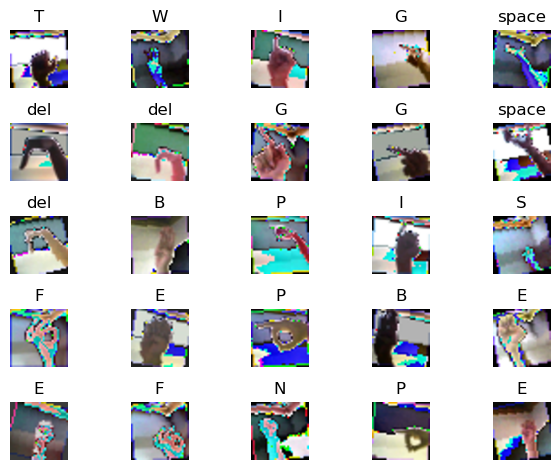

In [4]:
# load data to display
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_le)

# loads one batch of training data
batch = next(iter(train_loader)) 

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("LeNetTransforms.png")

### Training and Accuracy Functions

Below are the functions we created for getting the accuracy of our model and to actually train the model. Let's walk through the inner mechanisms of each. 

The evaluate() function works by calculating how predictions are equal to the true label of the image for each batch, in other words how many did the model predict right. Then it simply divides this number by the amount of images are in the data set, multiplies it by a 100, and voila there is the model's accuracy.  Additionally this also gets the average loss function value per batch. We get the average since the train dataset has more batches and hence a cumulative function will produce artificially large loss values for the train data. Important note to use torch.no_grad() in order to make sure that none of our calculation interfere with gradient values later on.

The train model is slightly more complex, though it is nothing out of the ordinary. During the function runtime we unpack each batch into image pixels and labels, next we get the prediction of the current model and use those to calculate the loss. For the loss function we use CrossEntropyLoss which is standard for multi-class classification problems like we have here. After we get the loss we calculate the gradients with respect to each weight by calling loss.backward() and then perform an update rule via the optimizer class. Additionally we use the same logic to get the accuracy as we do in the evaluate() function.

### Defining Parameters
Below we define our learning rate, epochs, and empty lists with loss and accuracy values. Additionally we initialize the model, optimizer, and the loss function.

Through trial and error of using a subset dataset we found that the more or less default learning rate of 0.001 was actually optimal for our training. Any larger values produced gradient steps that were too large and the model would overstep the global minimum. Additionally we chose the Adam optimizer since it helps use momentum to optimize the weights quicker, something we value greatly since our resources are limited and training models for a long time is quite constraining. 

This is a demonstration, LeNet training is done in train_lenet.py.

```
# some parameters for model training
learning_rate = 0.001
epochs = 30

# places to store historical metrics
lenet_train_losses = []; lenet_test_losses = []; 
lenet_train_accuracies = []; lenet_test_accuracies = []

# Perform workflow with LeNet
lenet = LeNet5().to(G_DEVICE)
optimizer = optim.Adam(lenet.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)
```

### Training the Model
This code simply calls the train function epoch amount of times and appends the accuracies and loss values. 

This is a demonstration, LeNet training is done in train_lenet.py
```
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(lenet, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    lenet_train_losses.append(train_loss)
    lenet_test_losses.append(test_loss)
    lenet_train_accuracies.append(train_accuracy)
    lenet_test_accuracies.append(test_accuracy)
```

In [5]:
# load the LeNet model
lenet = load_model("LeNet30Epoch.pth")
lenet_accuracy, lenet_loss = evaluate(lenet, test_loader = test_loader, loss_criteria = loss_criteria, device = G_DEVICE)
print(f"LENET ACCURACY {lenet_accuracy} LOSS {lenet_loss}")

LENET ACCURACY 91.79 LOSS 0.0020272083817298977


### Plotting Performance

To understand the model better we should visualize its training process. Below are the graphs of histories of loss function and accuracy over epochs. A strange phenomena occurs in the accuracy graph, the model performs significantly better on the test data compared to the training data! This can be explained by the fact that our training data utilizes data augmentation. With the augmented data the training data is messier and more difficult for the model to predict correctly, while the test data is simple and clean so the model does extremely well.

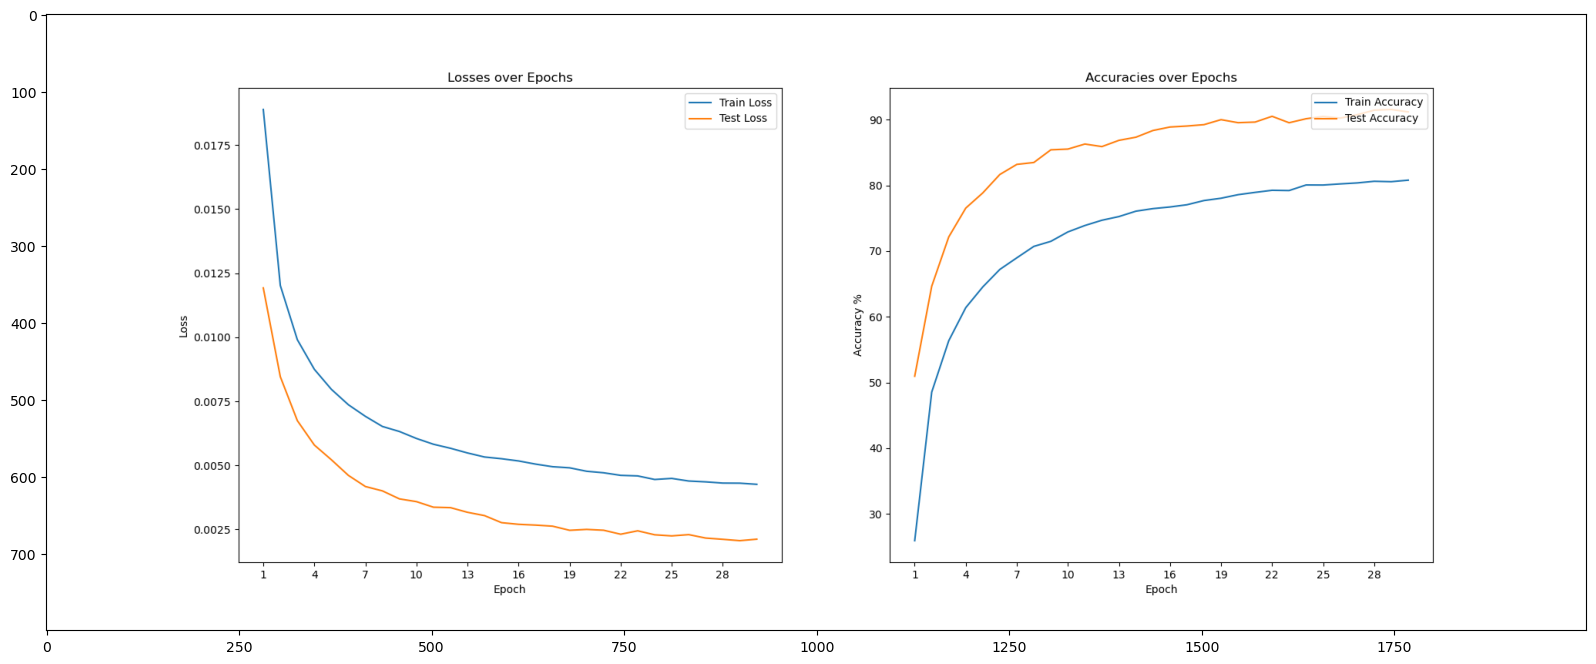

In [6]:
plt.figure(figsize = (20, 8))
plt.imshow(np.asarray(Image.open("LeNet30EpochHistory.png")))

The code below is for testing purposes rn. Also currently the validation set is more or less used as a test so maybe we abolish the test_loader all together...

### Confusion Matrix

Below we create a confusion matrix. This showcases the true labels on the y-axis and the predicted ones on the x-axis. Visually this tells us where the model gets confused and leads us to investigate some probelms within our plans. For example we can see that when the true label is "A" it predicts "E" and "S" frequently, this is due to the fact that all three of these letters are just a fist with different thumb positioning so even a human would struggle time to time.

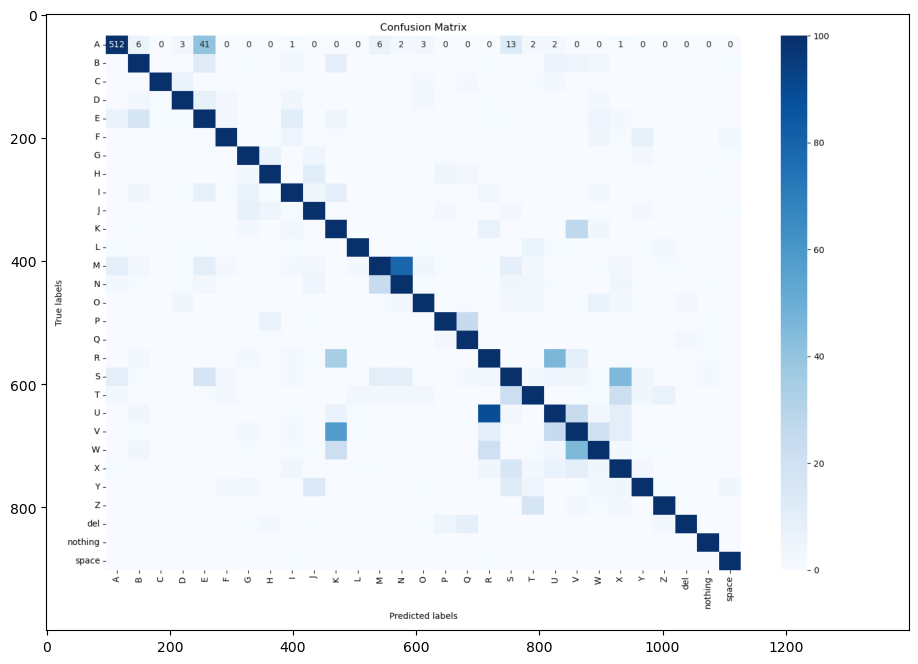

In [7]:
plt.figure(figsize = (20, 8))
plt.imshow(np.asarray(Image.open("LeNet30EpochConfusion.png")))

## AlexNet

AlexNet was invented by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, and it was introduced in 2012. Its architecture consists of eight layers: five convolutional layers, some of which are followed by max-pooling layers, and three fully connected layers. This model is significantly more advanced and deeper than the LeNet5, it has about thousand times the amount of weights (60 mil.) and takes an input of size 227x227x3. The last point is important to note since it allows the model to not lose details in some input and tell some of the similar signs apart better.

The steps below are identical to the LeNet5 model so we will only discuss the results.

In [8]:
# load data for AlexNet
train_loader, test_loader = split_dataloaders(G_TRAIN_IMG_PATH, train_size = 0.8, batch_size = G_BATCH_SIZE, num_workers = G_NUM_WORKERS, transform = train_transform_alex)

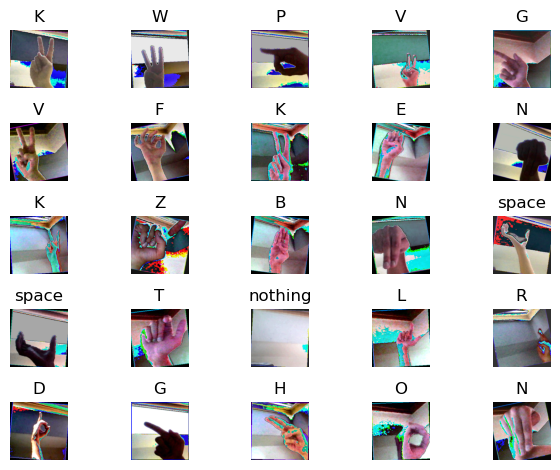

In [9]:
# loads one batch of training data
batch = next(iter(train_loader)) 

# displays grid of images and their labels
for i in range(25):
    
    image = transforms.ToPILImage()(batch[0][i])
    label = labels_names[batch[1][i].item()]
    resized_image = image.resize((256, 256))

    # plots the images and labels in a grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(label )
    
plt.tight_layout()
# save the figure
plt.savefig("AlexNetTransforms.png")

This is a demonstration, AlexNet should be trained in train_alexnet.py
```
# some parameters for model training
learning_rate = 0.001
epochs = 30

# places to store historical metrics
alex_train_losses = []; alex_test_losses = []; 
alex_train_accuracies = []; alex_test_accuracies = []

# Perform workflow with AlexNet
alex = AlexNet().to(G_DEVICE)
optimizer = optim.Adam(alex.parameters(), lr = learning_rate)
loss_criteria = nn.CrossEntropyLoss().to(G_DEVICE)
```

This is a demonstration, AlexNet should be trained in train_alexnet.py
```
# train AlexNet
for epoch in range(epochs):
    # get metrics
    train_loss, test_loss, train_accuracy, test_accuracy = train(alex, train_loader, test_loader, optimizer, loss_criteria, epoch)

    # populate arrays containing metric by epoch
    alex_train_losses.append(train_loss)
    alex_test_losses.append(test_loss)
    alex_train_accuracies.append(train_accuracy)
    alex_test_accuracies.append(test_accuracy)
```

### AlexNet Results

So it is clear to see that this model is much more powerful. The accuracy for the train and test data has improved drastically compared to the simpler LeNet5. Additionally the gap between the two subsets of the data is much smaller meaning that the model isn't as affected by the changes in data augmentation. Overall this model should be much better at our application of it on our webcam program we designed. A caviat to this model is that it took approximately eight times as long to train as it did for LeNet5.

In [10]:
# load the alexnet model
alex = load_model("AlexNet30Epoch.pth")
alex_accuracy, alex_loss = evaluate(alex, test_loader = test_loader, loss_criteria = loss_criteria, device = G_DEVICE)
print(f"ALEX ACCURACY {alex_accuracy} LOSS {alex_loss}")

ALEX ACCURACY 99.07 LOSS 0.00021916823761103938


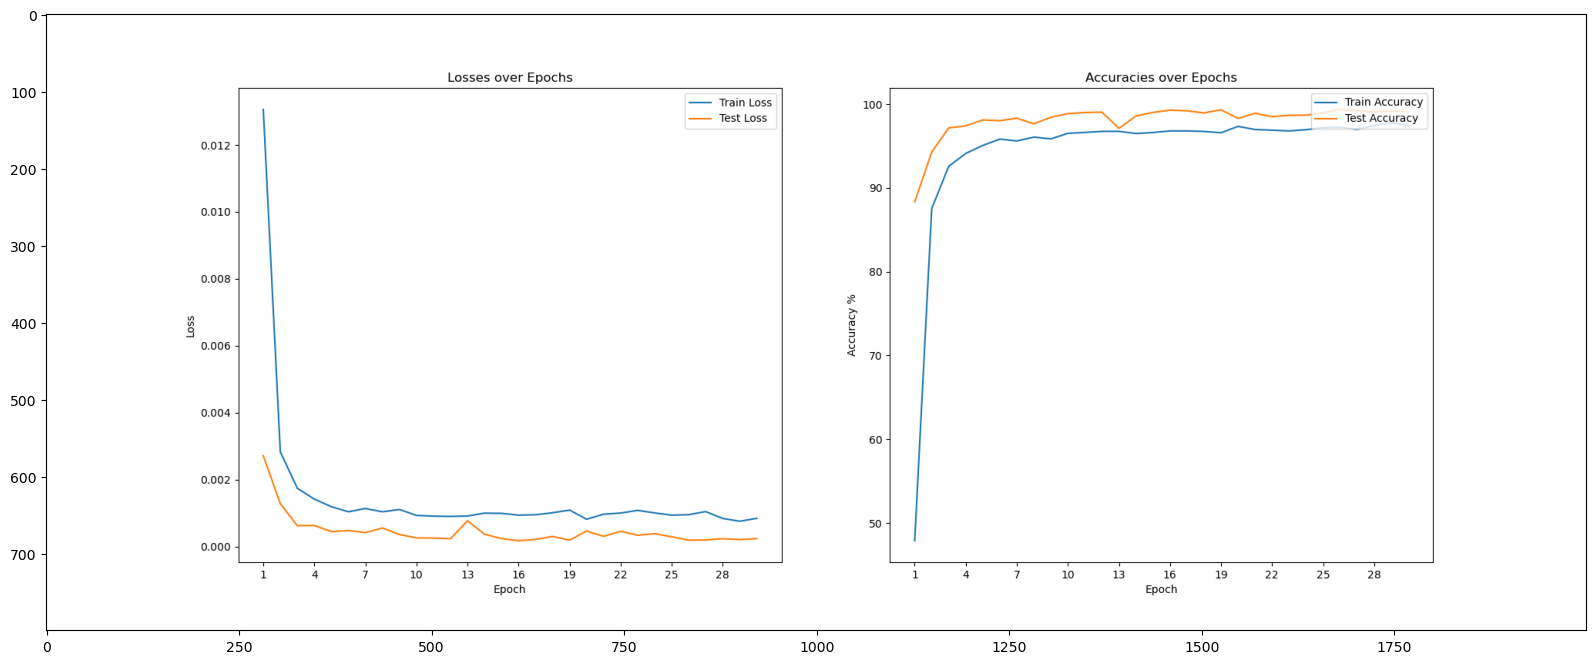

In [11]:
plt.figure(figsize = (20, 8))
plt.imshow(np.asarray(Image.open("AlexNet30EpochHistory.png")))

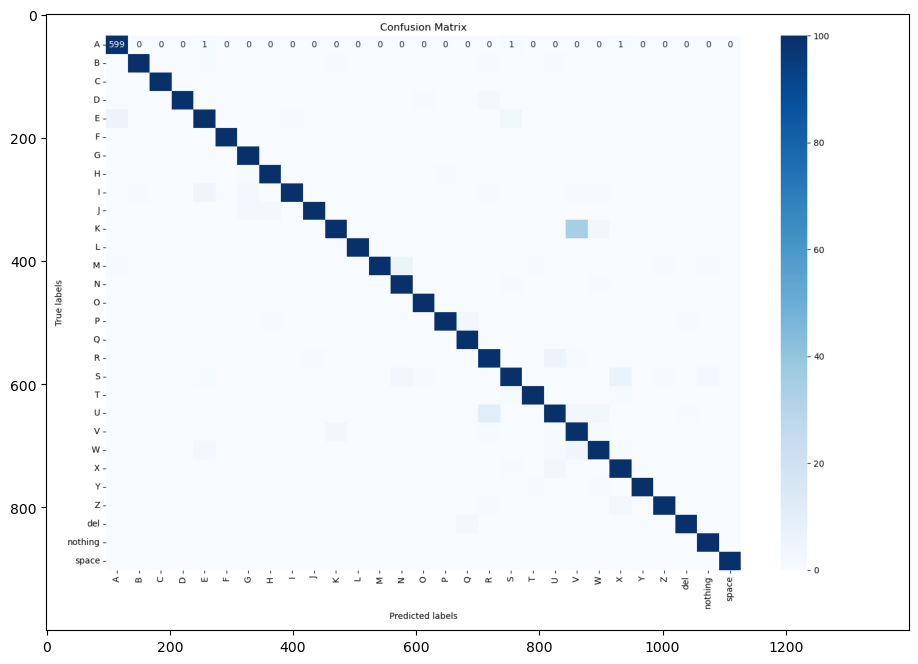

In [12]:
plt.figure(figsize = (20, 8))
plt.imshow(np.asarray(Image.open("AlexNet30EpochConfusion.png")))